In [1]:
### Installation info
# conda create -n detectron_env python=3.8
# conda activate detectron_env
# conda install cython
# conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia
# git clone https://github.com/facebookresearch/detectron2.git
# cd detectron2
# conda install -e .
# conda install opencv-python

In [2]:
### Virtual environment and notebook init
# Call conda activate detectron_env
# cd C:\R_projects\deep_learning_playground
# Call jupyter lab

In [3]:
### Check working directory
# pwd
### Check if entered correct environment
# conda info --envs

In [4]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Sep__8_19:56:38_Pacific_Daylight_Time_2023
Cuda compilation tools, release 12.3, V12.3.52
Build cuda_12.3.r12.3/compiler.33281558_0
torch:  2.1 ; cuda:  2.1.1
detectron2: 0.6


In [5]:
# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor,DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import ColorMode,GenericMask,Visualizer
from detectron2.structures.keypoints import heatmaps_to_keypoints
from detectron2.structures.keypoints_hack import heatmaps_to_keypoints2, heatmaps_to_keypoints_iterative, heatmaps_modify_iterative
from matplotlib import pyplot as plt
import glob
import random
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    DatasetEvaluator,
    inference_on_dataset,
    print_csv_format,
    verify_results,
)
import cv2 

In [6]:
#cv2.imshow("my_image", cv2.imread(r"C:\R_projects\deep_learning_playground\detectron2\demo\cat.jpg"))
#cv2.waitKey(0) 
#cv2.destroyAllWindows()

In [7]:
cd C:\R_projects\deep_learning_playground\detectron2\custom_data2

C:\R_projects\deep_learning_playground\detectron2\custom_data2


In [8]:
# Split training and test data
# !coco-split --has_annotations --valid_ratio 0 --test_ratio 0.1 --annotations_file ./coco_annotations.json

In [9]:
register_coco_instances("cat_data_train", {}, ".\coco_train.json", ".\datasets\caterpillar")
register_coco_instances("cat_data_test", {}, ".\coco_test.json", ".\datasets\caterpillar")
#register_coco_instances("cat_data_val", {}, ".\valid.json", ".\datasets\caterpillar")
MetadataCatalog.get("cat_data_train").set(thing_classes=["cat"])
MetadataCatalog.get("cat_data_train").set(thing_colors=(0,0,255))
MetadataCatalog.get("cat_data_test").set(thing_classes=["cat"])
MetadataCatalog.get("cat_data_test").set(thing_colors=(0,0,255))
MetadataCatalog.get("cat_data_train").set(keypoint_names=["head","middle","tail"])
MetadataCatalog.get("cat_data_train").set(keypoint_flip_map=[])
MetadataCatalog.get("cat_data_test").set(keypoint_names=["head","middle","tail"])
MetadataCatalog.get("cat_data_test").set(keypoint_flip_map=[])

namespace(name='cat_data_test',
          json_file='.\\coco_test.json',
          image_root='.\\datasets\\caterpillar',
          evaluator_type='coco',
          thing_classes=['cat'],
          thing_colors=(0, 0, 255),
          keypoint_names=['head', 'middle', 'tail'],
          keypoint_flip_map=[])

In [10]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime
import logging

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

from detectron2.data import DatasetMapper, build_detection_test_loader
from detectron2.engine import DefaultTrainer

class CustomTrainer(DefaultTrainer):
    """
    Custom Trainer deriving from the "DefaultTrainer"

    Overloads build_hooks to add a hook to calculate loss on the test set during training.
    """

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1, LossEvalHook(
            200, # Frequency of calculation - every 100 iterations here
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg, True)
            )
        ))

        return hooks


In [11]:
# from detectron2.config import LazyConfig, instantiate

# cfg = model_zoo.get_config("new_baselines/mask_rcnn_R_50_FPN_400ep_LSJ.py", trained=True)
# cfg.train.init_checkpoint = instantiate(cfg.model)
# cfg.dataloader.train.dataset.names = ("my_dataset_train",)
# cfg.dataloader.test.dataset.names = ("newdata_test", )
# cfg.train.max_iter = 3000
# cfg.train.output_dir = "./output2"
# cfg.train.log_period = 200
# cfg.train.eval_period = 200
# cfg.train.checkpointer.period = 2000
# cfg.train.checkpointer.max_to_keep=100
# cfg.model.proposal_generator.batch_size_per_image = 256
# cfg.model.roi_heads.num_classes = 1
# cfg.model.roi_heads.batch_size_per_image = 128
# cfg.model.roi_heads.test_score_thresh = 0.9
# cfg.optimizer.lr = 0.00015
# cfg.optimizer.weight_decay = 0
# os.makedirs(cfg.train.output_dir, exist_ok=True)

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("cat_data_train",)
cfg.DATASETS.TEST = ("cat_data_test", )
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.DATALOADER.NUM_WORKERS = 2
cfg.TEST.EVAL_PERIOD = 200
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00015  # pick a good LR
cfg.SOLVER.MAX_ITER = 3000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9
cfg.TEST.DETECTIONS_PER_IMAGE = 1
cfg.SOLVER.CHECKPOINT_PERIOD = 2000
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 3
cfg.TEST.KEYPOINT_OKS_SIGMAS = [0.1, 0.3, 0.1]
cfg.INPUT.RANDOM_FLIP = "horizontal"
cfg.MODEL.MASK_ON = True
cfg.MODEL.KEYPOINT_ON = True
cfg.MODEL.ROI_KEYPOINT_HEAD.LOSS_WEIGHT = 5
cfg.MODEL.ROI_KEYPOINT_HEAD.NORMALIZE_LOSS_BY_VISIBLE_KEYPOINTS = False
#cfg.MODEL.ROI_KEYPOINT_HEAD.ITERATIVE = True
cfg.INPUT.USE_DIFF = False                      # Include difference in green channel 10 frames ago as the 4th channel
cfg.OUTPUT_DIR = "./output5"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [12]:
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('cat_data_test',)
  TRAIN: ('cat_data_train',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
  USE_DIFF: False
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FE

In [ ]:
#trainer = DefaultTrainer(cfg)
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard --logdir "./output5"
# !del /S C:\Users\vsbpa\AppData\Local\Temp\.tensorboard-info

In [13]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0001999.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[12/12 13:13:49 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output5\model_0001999.pth ...


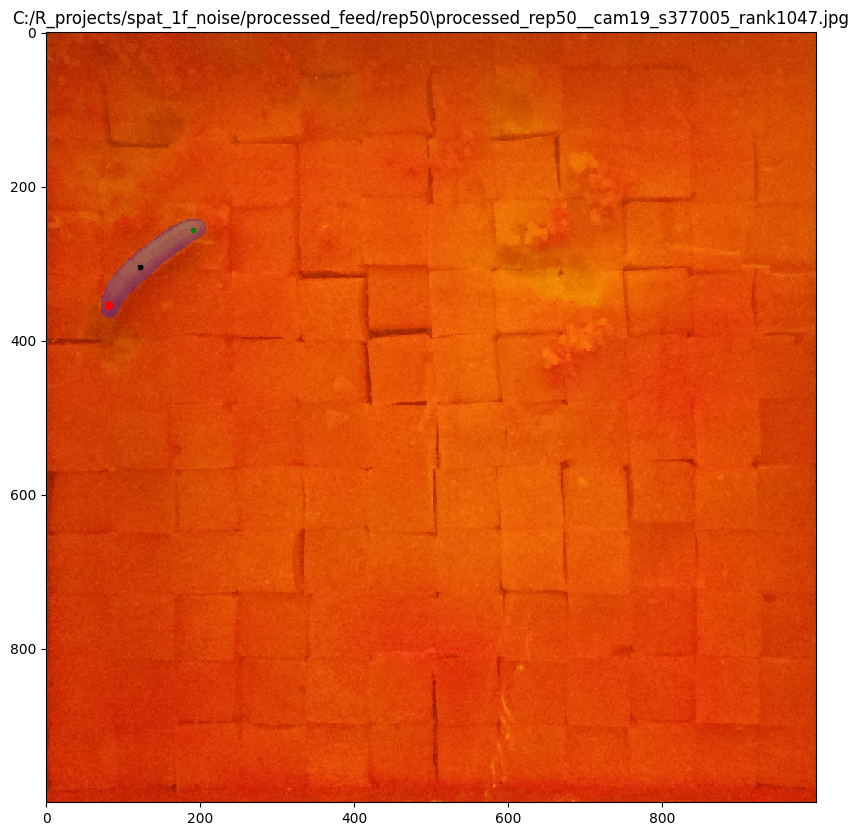

In [14]:
%matplotlib inline 

# f = glob.glob("C:\R_projects\deep_learning_playground\detectron2\custom_data\coco_dataset\*.jpg")
f = glob.glob("C:/R_projects/spat_1f_noise/processed_feed/rep50/*.jpg")
# f = ["C:/R_projects/spat_1f_noise/processed_feed/repweek2test2/processed_repweek2test2__cam28_s36764_rank103.jpg"]
fi = random.choice(f)
#fi = f[0]
im = cv2.imread(fi)
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("cat_data_train"), 
                   scale=1, 
               instance_mode=ColorMode.IMAGE_BW
)

#out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

try: out = v.draw_circle((outputs["instances"].pred_keypoints.tolist())[0][0][:2:], "red", radius = 5)
except: 
    print("Head not detected") 
    out =  v.draw_instance_predictions(outputs["instances"].to("cpu"))
try: out = v.draw_circle((outputs["instances"].pred_keypoints.tolist())[0][1][:2:], "black")
except: print("Middle not detected") 
try: out = v.draw_circle((outputs["instances"].pred_keypoints.tolist())[0][2][:2:], "green")
except: print("Tail not detected") 
try: out = v.draw_soft_mask(np.asarray(outputs["instances"].to("cpu").pred_masks)[0,:,:], "blue",alpha = 0.3)
except: print("Mask not detected") 

plt.figure(figsize = (10,10))
plt.imshow(out.get_image(), interpolation='nearest')
plt.title(fi)
plt.show()

In [23]:
f = glob.glob("C:/R_projects/deep_learning_playground/test_data/rep15/*[!_diff].jpg")
tot = len(f)
for i in range(tot):
    fi = f[i]
    im = cv2.imread(fi)
    outputs = predictor(im) 
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("cat_data_train"), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW
    )
    #out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    try: out = v.draw_box(outputs["instances"].pred_boxes.tensor.tolist()[0])
    except: out = v.draw_circle((0,0), radius = 0, color = "black")
    try: out = v.draw_circle((outputs["instances"].pred_keypoints.tolist())[0][0][:2:], color = "red", radius = 3)
    except: 1
    try: out = v.draw_circle((outputs["instances"].pred_keypoints.tolist())[0][1][:2:], color = "black", radius = 2)
    except: 1
    try: out = v.draw_circle((outputs["instances"].pred_keypoints.tolist())[0][2][:2:], color = "green", radius = 2)
    except: 1
    try: out = v.draw_soft_mask(np.asarray(outputs["instances"].to("cpu").pred_masks)[0,:,:], "blue",alpha = 0.3)
    except: 1
    fp = os.path.join("C:/R_projects/deep_learning_playground/detectron2/custom_data2/model5_vid_pred_15", os.path.basename(fi))
    cv2.imwrite(fp, cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB))
    print(f"{i+1} of {tot}", end = "\r")

In [158]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0001999.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # set a custom testing threshold
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("cat_data_test",tasks=["bbox","segm","keypoints"], distributed=False, max_dets_per_image=1, 
                          use_fast_impl=False, allow_cached_coco= False, output_dir="./output/", kpt_oks_sigmas = [0.1,0.5,0.1])
val_loader = build_detection_test_loader(cfg, "cat_data_test")
detectron2.evaluation.inference_on_dataset(predictor.model, val_loader, evaluator)

[12/12 15:10:32 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output5\model_0001999.pth ...
[12/12 15:10:32 d2.data.datasets.coco]: Loaded 43 images in COCO format from .\coco_test.json
[12/12 15:10:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/12 15:10:32 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/12 15:10:32 d2.data.common]: Serializing 43 elements to byte tensors and concatenating them all ...
[12/12 15:10:32 d2.data.common]: Serialized dataset takes 0.03 MiB
[12/12 15:10:32 d2.evaluation.evaluator]: Start inference on 43 batches
[12/12 15:10:39 d2.evaluation.evaluator]: Inference done 11/43. Dataloading: 0.0006 s/iter. Inference: 0.2584 s/iter. Eval: 0.0034 s/iter. Total: 0.2624 s/iter. ETA=0:00:08
[12/12 15:10:44 d2.evaluation.evaluator]: Inference done 30/43. Dataloa

OrderedDict([('bbox',
              {'AP': 66.82083896648773,
               'AP50': 85.04429390307452,
               'AP75': 81.96977592496091,
               'APs': 18.019801980198018,
               'APm': 73.8372530530364,
               'APl': nan}),
             ('keypoints',
              {'AP': 61.40855938751978,
               'AP50': 76.33892732902635,
               'AP75': 65.31009881876219,
               'APm': 71.77428060696703,
               'APl': nan}),
             ('segm',
              {'AP': 59.750544186904264,
               'AP50': 85.04429390307452,
               'AP75': 76.55109140257656,
               'APs': 12.871287128712869,
               'APm': 64.4196721710669,
               'APl': nan})])

In [ ]:
nuts_metadata = MetadataCatalog.get('cat_data_test')
dataset_dicts = DatasetCatalog.get("cat_data_test")
fig = plt.figure(figsize=(15,30)) 

i = 0
for d in dataset_dicts:
    i += 1
    fig.add_subplot(11, 4, i) 
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], metadata=nuts_metadata , scale=0.5, instance_mode= ColorMode.IMAGE_BW)
    try: out = v.draw_box(outputs["instances"].pred_boxes.tensor.tolist()[0])
    except: out = v.draw_circle((0,0), radius = 0, color = "black")
    try: out = v.draw_circle((outputs["instances"].pred_keypoints.tolist())[0][0][:2:], color = "red", radius = 3)
    except: 1
    try: out = v.draw_circle((outputs["instances"].pred_keypoints.tolist())[0][1][:2:], color = "black", radius = 2)
    except: 1
    try: out = v.draw_circle((outputs["instances"].pred_keypoints.tolist())[0][2][:2:], color = "green", radius = 2)
    except: 1
    try: out = v.draw_soft_mask(np.asarray(outputs["instances"].to("cpu").pred_masks)[0,:,:], "blue",alpha = 0.3)
    except: 1
    #out = v.draw_dataset_dict(d)
    plt.title(os.path.basename(d["file_name"]))
    plt.imshow(out.get_image())
    fp = os.path.join("C:/R_projects/deep_learning_playground/detectron2/custom_data2/vid_pred2", os.path.basename(d["file_name"]))
    cv2.imwrite(fp, cv2.cvtColor(out.get_image()[:,:,0:3], cv2.COLOR_BGR2RGB))
    


In [ ]:
fig = plt.figure(figsize=(9,80)) 

for i in range(len(dataset_dicts)):
    fi = dataset_dicts[i]["file_name"]
    img = cv2.imread(fi)
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], metadata=nuts_metadata , scale= 0.3, instance_mode= ColorMode.IMAGE_BW)
    try: out = v.draw_circle((outputs["instances"].pred_keypoints.tolist())[0][0][:2:], "red", radius = 5)
    except: 
        print("Head not detected")  
    try: out =  v.draw_box(outputs["instances"].to("cpu").pred_boxes.tensor.tolist()[0])
    except: 
        print("Box not detected") 
        out =  v.draw_instance_predictions(outputs["instances"].to("cpu"))
    try: out = v.draw_circle((outputs["instances"].pred_keypoints.tolist())[0][1][:2:], "black")
    except: print("Middle not detected") 
    try: out = v.draw_circle((outputs["instances"].pred_keypoints.tolist())[0][2][:2:], "green")
    except: print("Tail not detected") 
    try: out = v.draw_soft_mask(np.asarray(outputs["instances"].to("cpu").pred_masks)[0,:,:], "blue",alpha = 0.3)
    except: print("Mask not detected") 
    #out = visualizer.draw_dataset_dict(d)
    plt.title(os.path.basename(fi))
    fig.add_subplot(21, 2, i+1) 
    plt.imshow(out.get_image(), interpolation='nearest')


In [ ]:
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.data import MetadataCatalog, DatasetCatalog


#MetadataCatalog.get('test').set(thing_classes=["first"])

#MetadataCatalog.get('cat_data_test')
outputs
convert_to_coco_dict(outputs)

In [141]:

#dataset

In [146]:
import csv

def write_csv(path, df):
    keys = dataset[0].keys()
    with open(path, "w", newline = "") as output_file: 
        dict_writer = csv.DictWriter(output_file, keys)
        dict_writer.writeheader()
        dict_writer.writerows(df)

def img_inference(predictor, rep_ID, root_path):
    dataset = []
    f = glob.glob(os.path.join(root_path, rep_ID,"*[!_diff].jpg"))
    tot = len(f)
    for i in range(tot):
        print(f"{i+1} of {tot}", end = "\r")
        fi = f[i]
        inst = predictor(cv2.imread(fi))["instances"].to("cpu")
        data = {}
        data["file_name"] = fi
        data["image_size"] = list(inst.image_size)
        try: data["thing_class"] = MetadataCatalog.get('cat_data_test').get("thing_classes")[inst.pred_classes[0]]
        except: data["thing_class"] = "NA"
        try: data["keypoints"] = np.array(inst.pred_keypoints.tolist()[0]).ravel().tolist()
        except: data["keypoints"] = "NA"
        try: data["bbox"] = inst.pred_boxes.tensor.tolist()[0]
        except: data["bbox"] = "NA"
        try:
            cont, _ = cv2.findContours(inst.pred_masks.numpy()[0,:,:].astype('uint8'),cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
            data["polygon"] = cont[0].ravel().tolist()
        except: 
            data["polygon"] = "NA"
        dataset.append(data)
    return(dataset)

def write_img_inference(predictor, write_path, rep_ID, read_path):
    df = img_inference(predictor, rep_ID, read_path)
    write_csv(os.path.join(write_path, rep_ID + "_inference.csv"), df)



In [147]:
write_img_inference(
    predictor, 
    write_path = "C:/R_projects/deep_learning_playground",
    rep_ID = "rep50",
    read_path = "C:/R_projects/spat_1f_noise/processed_feed"
)

In [157]:
[os.path.basename(x) 
 for x in 
 glob.glob("C:/R_projects/spat_1f_noise/processed_feed/rep[!week][!trial]*", recursive=False)]


['rep10',
 'rep11',
 'rep12',
 'rep13',
 'rep14',
 'rep15',
 'rep16',
 'rep17',
 'rep18',
 'rep19',
 'rep20',
 'rep21',
 'rep22',
 'rep23',
 'rep24',
 'rep25',
 'rep26',
 'rep27',
 'rep28',
 'rep29',
 'rep30',
 'rep31',
 'rep32',
 'rep33',
 'rep34',
 'rep35',
 'rep36',
 'rep37',
 'rep38',
 'rep39',
 'rep40',
 'rep41',
 'rep42',
 'rep44',
 'rep45',
 'rep46',
 'rep47',
 'rep48',
 'rep49',
 'rep50',
 'rep51',
 'rep52',
 'rep53',
 'rep54',
 'rep55',
 'rep56',
 'rep57',
 'rep58',
 'rep59',
 'rep60',
 'rep61',
 'rep62',
 'rep63',
 'rep64',
 'rep65',
 'rep66',
 'rep67',
 'rep68',
 'rep69',
 'rep70',
 'rep71',
 'rep72',
 'rep73',
 'rep74',
 'rep75',
 'rep77',
 'rep78',
 'rep79',
 'rep80',
 'rep81',
 'rep82',
 'rep83',
 'rep84',
 'rep85',
 'rep86',
 'rep87',
 'rep88',
 'rep89',
 'rep90',
 'rep91']

In [ ]:
from shapely.geometry import Polygon

csv_df = pd.DataFrame()
    for prediction in glob.glob(os.getcwd() + r"\dataset\predictions\*pkl"):
        fileName_absolute = os.path.basename(prediction)                 ## get the file name 
        print("The pkl_file name: ", fileName_absolute)
        # Read the pkl file
        pickleFile = open(prediction,"rb")
        pickel_Info = pickle.load(pickleFile)
        
        # Get the 'pred_boxes' values in the pkl file:
        boxes = (
            pickel_Info["prediction"]["instances"]
            .get_fields()["pred_boxes"]
            .tensor.cpu()
            .numpy()
        )
    
        # Get the 'pred_mask' values in the pkl file:
        masks = (
            pickel_Info["prediction"]["instances"]
            .get_fields()["pred_masks"]
            .cpu()
            .numpy()
            .astype('uint8')
        )
    
        # Extract the 'contour' of each 'pred_box' by converting pred_box boolean to a 8-bit numpy array:
        # Refer to this post to get and visualise the contours: https://stackoverflow.com/questions/73217530/extract-the-masks-values-from-detectron2-object-detection-segmentation-and-then
        contours = []
        for pred_mask in pickel_Info["prediction"]['instances'].pred_masks:
            mask = pred_mask.cpu().numpy().astype('uint8')
            contour, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
            contours.append(contour[0]) # contour is a tuple (OpenCV 4.5.2), so take the first element which is the array of contour points
        
    
        # save boxes and masks-polygons
        dataset = []
        counter_box = 0
        for i, box in enumerate(boxes):
            data = {}
            data["file_name"] = pickel_Info['file_name']
            data["file_location"] = pickel_Info["file_location"]
            data["image_height"] = pickel_Info["prediction"]["instances"].image_size[0]
            data["image_width"] = pickel_Info["prediction"]["instances"].image_size[1]
            data["bounding_box"] = box
            data["mask"] = masks[i]
            data["contours"] = contours[i]
            data["polygon"] = Polygon(np.squeeze(contours[i]))
            data["id"] = "id_{counter_box}"
            counter_box = counter_box + 1
    
            dataset.append(data)
    
        df = pd.DataFrame(dataset)
    
        
        # keep specific columns for the csv file
        df = df[
            [
                "file_name",
                "id",
                "bounding_box",
                "polygon",
            ]
        ]
    
        csv_df = csv_df.append(df)
    print ('## csv_df: ', csv_df)